In [ ]:
import os
import numpy as np
import fitsio
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
import corner

global_counter = 0  # Initialize global counter

def extract_data_from_fits(file_path):
    with fitsio.FITS(file_path) as hdul:
        redshifts = hdul[1]['ELG_Z'][:]
        flux = hdul[1]['FLUX'][:]
    return flux, redshifts

def save_config(lr, input_layer, n_node_CNN, n_node_FC, count):
    config_dict = {'lr': lr, 'input_layer': input_layer, 'n_node_CNN': n_node_CNN, 'n_node_FC': n_node_FC}

    directory_path = f'Config/Config{count}/'

    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    file_path = os.path.join(directory_path, f'custom_config{count}.json')
    with open(file_path, 'w') as json_file:
        json.dump(config_dict, json_file)
        print('Saved config to:', file_path)

def save_normalization_params(mean, std, count):
    norm_params = {'mean': mean, 'std': std}
    directory_path = f'NormalizationParams/'

    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    file_path = os.path.join(directory_path, f'norm_params_{count}.json')
    with open(file_path, 'w') as json_file:
        json.dump(norm_params, json_file)
        print('Saved normalization parameters to:', file_path)

def network(X_train, X_valid, y_train, y_valid, lr, runid, input_layer, n_node_CNN, n_node_FC):
    global global_counter  # Declare global_counter as global if you modify it

    input_shape = (X_train.shape[1], 1)
    inputs = Input(shape=input_shape)

    x = Conv1D(input_layer, kernel_size=5, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    for k in n_node_CNN:
        x = Conv1D(k, kernel_size=5, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    for n in n_node_FC:
        x = Dense(n, activation='relu')(x)

    outputs = Dense(1)(x)  # No activation for regression

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

    log_dir = f"logs/fit_{runid}/"
    os.makedirs(log_dir, exist_ok=True)

    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    X_train = np.expand_dims(X_train, axis=-1)
    X_valid = np.expand_dims(X_valid, axis=-1)

    best_mae = float('inf')
    best_epoch = 0
    best_weights = None

    history = model.fit(
        X_train, y_train, 
        epochs=10, 
        validation_data=(X_valid, y_valid), 
        callbacks=[tensorboard_callback]
    )

    val_mae = history.history['val_mae']
    for epoch, mae in enumerate(val_mae):
        if mae < best_mae:
            best_mae = mae
            best_epoch = epoch
            best_weights = model.get_weights()

    print(f"Best Epoch: {best_epoch + 1}, Best MAE: {best_mae}")
    model.set_weights(best_weights)

    best_weights_path = f'best_weights_{runid}.h5'
    model.save_weights(best_weights_path)
    print(f'Saved best weights to: {best_weights_path}')

    y_pred_valid = model.predict(X_valid)

    save_config(lr, input_layer, n_node_CNN, n_node_FC, global_counter)
    global_counter += 1  # Increment global_counter after each run

    return history, model, y_pred_valid

def plot_predicted_vs_true(y_true, y_pred, runid):
    # Ensure y_true and y_pred are 1D arrays
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    data = np.vstack([y_true, y_pred]).T

    # Determine the axis limits for the scatter plot
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))

    # Set a buffer around the min and max values for better visualization
    buffer = 0.1 * (max_val - min_val)
    axis_min = min_val - buffer
    axis_max = max_val + buffer

    fig = corner.corner(
        data, 
        labels=["Z$_{True}$", "Z$_{Predict}$"],
        bins=50,
        quantiles=[0.16, 0.5, 0.84], 
        show_titles=True, 
        title_kwargs={"fontsize": 12},
        plot_contours=True, 
        fill_contours=False,  # Do not fill contours
        levels=(0.68, 0.95, 0.997),
        color='b',
        contour_kwargs={"colors": ["blue", "green", "red"]}
    )

    # Add the y = x line to the main plot
    axes = np.array(fig.axes).reshape((2, 2))

    # Set axis limits for the main scatter plot
    main_scatter = axes[1, 0]
    main_scatter.set_xlim(axis_min, axis_max)
    main_scatter.set_ylim(axis_min, axis_max)
    main_scatter.plot([axis_min, axis_max], [axis_min, axis_max], 'k--', lw=2)

    plt.suptitle(f'Predicted vs. True Redshift for Run ID: {runid}', fontsize=16)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
    plt.savefig(f'pred_vs_true_{runid}.png', dpi=300)
    plt.show()
    
def array_user(flux, redshifts, configs):
    history_list = []

    for config in configs:
        lr = config['lr']
        simid = config['simid']
        input_layer = config['input_layer']
        n_node_CNN = config['n_node_CNN']
        n_node_FC = config['n_node_FC']

        runid = f"{simid}_{global_counter}"
        
        X_train, X_valid, y_train, y_valid = train_test_split(flux, redshifts, train_size=0.7)

        mean_train = np.mean(X_train)
        std_train = np.std(X_train)
        
        X_train = (X_train - mean_train) / std_train
        X_valid = (X_valid - mean_train) / std_train

        history, model, y_pred_valid = network(X_train, X_valid, y_train, y_valid, lr, runid, input_layer, n_node_CNN, n_node_FC)

        save_normalization_params(mean_train, std_train, global_counter)

        plot_predicted_vs_true(y_valid, y_pred_valid, runid)

        history_list.append((history, runid))

    return history_list

def process_multiple_fits(directory, configs, max_files=None):
    flux_list = []
    redshifts_list = []
    
    fits_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.fits')]
    
    if max_files is not None:
        fits_files = fits_files[:max_files]
        
    for fits_file in fits_files:
        print(f"Processing file: {fits_file}")
        flux, redshifts = extract_data_from_fits(fits_file)
        flux_list.append(flux)
        redshifts_list.append(redshifts)
    
    all_flux = np.concatenate(flux_list, axis=0)
    all_redshifts = np.concatenate(redshifts_list, axis=0)
    
    array_user(all_flux, all_redshifts, configs)

# Example usage
directory = 'MainQSO/RedshiftSample'
configs = [{'lr': 1e-3, 'do': None, 'bs': None, 'simid': 'lr', 'input_layer': 50, 'n_node_CNN': [100, 100, 100, 100, 100], 'n_node_FC': [30, 25]}]
process_multiple_fits(directory, configs, max_files=None)


Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch64.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch78.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch63.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch230.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch67.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch9.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch265.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch58.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch69.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch60.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch252.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch87.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch81.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_bat

2024-09-20 14:54:47.094097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-20 14:54:48.964518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38218 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-09-20 14:54:48.966350: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38218 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-09-20 14:54:48.967940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

Loaded pretrained weights from: Redshift.h5
Epoch 1/10


2024-09-20 14:54:58.469681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2024-09-20 14:55:00.728557: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7147/7147 [==============================] - 57s 7ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0183 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0159
Epoch 2/10
7147/7147 [==============================] - 51s 7ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0137 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0133
Epoch 3/10
7147/7147 [==============================] - 52s 7ms/step - loss: 7.4300e-04 - mse: 7.4300e-04 - mae: 0.0108 - val_loss: 9.9351e-04 - val_mse: 9.9351e-04 - val_mae: 0.0111
Epoch 4/10
7147/7147 [==============================] - 51s 7ms/step - loss: 5.2256e-04 - mse: 5.2256e-04 - mae: 0.0091 - val_loss: 9.2057e-04 - val_mse: 9.2057e-04 - val_mae: 0.0096
Epoch 5/10
7147/7147 [==============================] - 51s 7ms/step - loss: 3.7068e-04 - mse: 3.7068e-04 - mae: 0.0079 - val_loss: 8.7276e-04 - val_mse: 8.7276e-04 - val_mae: 0.0089
Epoch 6/10
7147/7147 [==============================] - 51s 7ms/step - loss: 2.8675e-04 - mse: 2.8675e-04 - mae: 0.0071 - val_lo

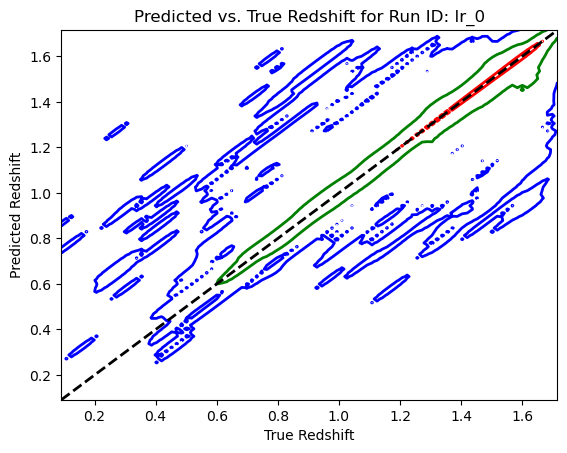

In [6]:
import os
import numpy as np
import fitsio
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
import corner
from scipy.stats import gaussian_kde
from tensorflow.keras.optimizers.schedules import ExponentialDecay

global_counter = 0  # Initialize global counter

def extract_data_from_fits(file_path):
    with fitsio.FITS(file_path) as hdul:
        redshifts = hdul[1]['ELG_Z'][:]
        flux = hdul[1]['FLUX'][:]
    return flux, redshifts

def save_config(lr, input_layer, n_node_CNN, n_node_FC, count):
    config_dict = {'lr': lr, 'input_layer': input_layer, 'n_node_CNN': n_node_CNN, 'n_node_FC': n_node_FC}

    directory_path = f'Config/Config{count}/'

    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    file_path = os.path.join(directory_path, f'custom_config{count}.json')
    with open(file_path, 'w') as json_file:
        json.dump(config_dict, json_file)
        print('Saved config to:', file_path)

def network(X_train, X_valid, y_train, y_valid, initial_lr, runid, input_layer, n_node_CNN, n_node_FC, pretrained=True):
    global global_counter  # Declare global_counter as global if you modify it

    input_shape = (X_train.shape[1], 1)
    inputs = Input(shape=input_shape)

    x = Conv1D(input_layer, kernel_size=5, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    for k in n_node_CNN:
        x = Conv1D(k, kernel_size=5, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    for n in n_node_FC:
        x = Dense(n, activation='relu')(x)

    outputs = Dense(1)(x)  # No activation for regression

    model = Model(inputs=inputs, outputs=outputs)
    
    # Define the learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,  # Number of steps before the learning rate is decayed
        decay_rate=0.93,    # Factor by which the learning rate will be decayed
        staircase=True     # If True, learning rate decays at discrete intervals
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

    log_dir = f"logs/fit_{runid}/"
    os.makedirs(log_dir, exist_ok=True)

    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    X_train = np.expand_dims(X_train, axis=-1)
    X_valid = np.expand_dims(X_valid, axis=-1)

    # Check if pre-trained weights exist
    best_weights_path = f'Redshift.h5'
    if pretrained and os.path.exists(best_weights_path):
        model.load_weights(best_weights_path)
        print(f"Loaded pretrained weights from: {best_weights_path}")

    best_mae = float('inf')
    best_epoch = 0
    best_weights = None

    history = model.fit(
        X_train, y_train, 
        epochs=10, 
        validation_data=(X_valid, y_valid), 
        callbacks=[tensorboard_callback]
    )

    val_mae = history.history['val_mae']
    for epoch, mae in enumerate(val_mae):
        if mae < best_mae:
            best_mae = mae
            best_epoch = epoch
            best_weights = model.get_weights()

    print(f"Best Epoch: {best_epoch + 1}, Best MAE: {best_mae}")
    model.set_weights(best_weights)

    # Save the best model weights
    model.save_weights(best_weights_path)
    print(f'Saved best weights to: {best_weights_path}')

    y_pred_valid = model.predict(X_valid)

    save_config(initial_lr, input_layer, n_node_CNN, n_node_FC, global_counter)
    global_counter += 1  # Increment global_counter after each run

    return history, model, y_pred_valid

def plot_predicted_vs_true(y_true, y_pred, runid):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))

    x = np.linspace(min_val, max_val, 100)
    y = np.linspace(min_val, max_val, 100)
    X, Y = np.meshgrid(x, y)
    
    data = np.vstack([y_true, y_pred])
    kde = gaussian_kde(data)
    
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(grid_points).reshape(X.shape)
    
    Z = Z / Z.max()  # Normalize to range [0, 1] for contours
    levels = [0.68, 0.95, 0.997]  # Approximate 1, 2, 3 sigma levels

    np.save('scatter_array.npy', {'y_true': y_true, 'y_pred': y_pred})

    contour = plt.contour(X, Y, Z, levels=[np.percentile(Z, 100 * level) for level in levels], 
                          colors=['blue', 'green', 'red'], 
                          linewidths=2, linestyles='-')
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.xlabel('True Redshift')
    plt.ylabel('Predicted Redshift')
    plt.title(f'Predicted vs. True Redshift for Run ID: {runid}')
    
    plt.savefig(f'pred_vs_true_{runid}.png', dpi=300)
    plt.show()
    
def array_user(flux, redshifts, configs):
    history_list = []

    valid_indices = redshifts != 0
    filtered_flux = flux[valid_indices]
    filtered_redshifts = redshifts[valid_indices]

    for config in configs:
        lr = config['lr']
        simid = config['simid']
        input_layer = config['input_layer']
        n_node_CNN = config['n_node_CNN']
        n_node_FC = config['n_node_FC']

        runid = f"{simid}_{global_counter}"
        
        X_train, X_valid, y_train, y_valid = train_test_split(filtered_flux, filtered_redshifts, train_size=0.7)

        X_train = np.array([(x - np.mean(x)) / np.std(x) for x in X_train])
        X_valid = np.array([(x - np.mean(x)) / np.std(x) for x in X_valid])

        X_train = np.array([x / np.max(np.abs(x)) for x in X_train])
        X_valid = np.array([x / np.max(np.abs(x)) for x in X_valid])
        print(len(filtered_flux))

        pretrained = True  # Set this flag to True if you want to load pretrained weights

        history, model, y_pred_valid = network(X_train, X_valid, y_train, y_valid, lr, runid, input_layer, n_node_CNN, n_node_FC, pretrained)

        plot_predicted_vs_true(y_valid, y_pred_valid, runid)

        history_list.append((history, runid))

    return history_list

def process_multiple_fits(directory, configs, max_files=None):
    flux_list = []
    redshifts_list = []
    
    fits_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.fits')]
    
    if max_files is not None:
        fits_files = fits_files[:max_files]
        
    for fits_file in fits_files:
        print(f"Processing file: {fits_file}")
        flux, redshifts = extract_data_from_fits(fits_file)
        flux_list.append(flux)
        redshifts_list.append(redshifts)
    
    all_flux = np.concatenate(flux_list, axis=0)
    all_redshifts = np.concatenate(redshifts_list, axis=0)
    
    array_user(all_flux, all_redshifts, configs)

# Example usage
directory = 'MainQSO/Redshift'
configs = [{'lr': 1e-3, 'do': None, 'bs': None, 'simid': 'lr', 'input_layer': 50, 'n_node_CNN': [50, 50, 100, 100, 100], 'n_node_FC': [30, 25]}]
process_multiple_fits(directory, configs, max_files=None)


In [1]:
import os
import numpy as np
import fitsio
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
import corner
from scipy.stats import gaussian_kde
from tensorflow.keras.optimizers.schedules import ExponentialDecay

global_counter = 0  # Initialize global counter

def extract_data_from_fits(file_path):
    with fitsio.FITS(file_path) as hdul:
        redshifts = hdul[1]['ELG_Z'][:]
        flux = hdul[1]['FLUX'][:]
    return flux, redshifts

def save_config(lr, input_layer, n_node_CNN, n_node_FC, count):
    config_dict = {'lr': lr, 'input_layer': input_layer, 'n_node_CNN': n_node_CNN, 'n_node_FC': n_node_FC}

    directory_path = f'Config/Config{count}/'

    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    file_path = os.path.join(directory_path, f'custom_config{count}.json')
    with open(file_path, 'w') as json_file:
        json.dump(config_dict, json_file)
        print('Saved config to:', file_path)

def network(X_train, X_valid, y_train, y_valid, initial_lr, runid, input_layer, n_node_CNN, n_node_FC, pretrained=True):
    global global_counter  # Declare global_counter as global if you modify it

    input_shape = (X_train.shape[1], 1)
    inputs = Input(shape=input_shape)

    x = Conv1D(input_layer, kernel_size=5, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    for k in n_node_CNN:
        x = Conv1D(k, kernel_size=5, activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)

    x = Flatten()(x)
    for n in n_node_FC:
        x = Dense(n, activation='relu')(x)

    outputs = Dense(1)(x)  # No activation for regression

    model = Model(inputs=inputs, outputs=outputs)
    
    # Define the learning rate schedule
    lr_schedule = ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=1000,  # Number of steps before the learning rate is decayed
        decay_rate=0.93,    # Factor by which the learning rate will be decayed
        staircase=True     # If True, learning rate decays at discrete intervals
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse', 'mae'])

    log_dir = f"logs/fit_{runid}/"
    os.makedirs(log_dir, exist_ok=True)

    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    X_train = np.expand_dims(X_train, axis=-1)
    X_valid = np.expand_dims(X_valid, axis=-1)

    # Check if pre-trained weights exist
    best_weights_path = f'Redshift.h5'
    if pretrained and os.path.exists(best_weights_path):
        model.load_weights(best_weights_path)
        print(f"Loaded pretrained weights from: {best_weights_path}")

    best_mae = float('inf')
    best_epoch = 0
    best_weights = None

    history = model.fit(
        X_train, y_train, 
        epochs=10, 
        validation_data=(X_valid, y_valid), 
        callbacks=[tensorboard_callback]
    )

    val_mae = history.history['val_mae']
    for epoch, mae in enumerate(val_mae):
        if mae < best_mae:
            best_mae = mae
            best_epoch = epoch
            best_weights = model.get_weights()

    print(f"Best Epoch: {best_epoch + 1}, Best MAE: {best_mae}")
    model.set_weights(best_weights)

    # Save the best model weights
    model.save_weights(best_weights_path)
    print(f'Saved best weights to: {best_weights_path}')

    y_pred_valid = model.predict(X_valid)

    save_config(initial_lr, input_layer, n_node_CNN, n_node_FC, global_counter)
    global_counter += 1  # Increment global_counter after each run

    return history, model, y_pred_valid

def plot_predicted_vs_true(y_true, y_pred, runid):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))

    x = np.linspace(min_val, max_val, 100)
    y = np.linspace(min_val, max_val, 100)
    X, Y = np.meshgrid(x, y)
    
    data = np.vstack([y_true, y_pred])
    kde = gaussian_kde(data)
    
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(grid_points).reshape(X.shape)
    
    Z = Z / Z.max()  # Normalize to range [0, 1] for contours
    levels = [0.68, 0.95, 0.997]  # Approximate 1, 2, 3 sigma levels

    np.save('scatter_array.npy', {'y_true': y_true, 'y_pred': y_pred})

    contour = plt.contour(X, Y, Z, levels=[np.percentile(Z, 100 * level) for level in levels], 
                          colors=['blue', 'green', 'red'], 
                          linewidths=2, linestyles='-')
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.xlabel('True Redshift')
    plt.ylabel('Predicted Redshift')
    plt.title(f'Predicted vs. True Redshift for Run ID: {runid}')
    
    plt.savefig(f'pred_vs_true_{runid}.png', dpi=300)
    plt.show()
    
def array_user(flux, redshifts, configs):
    history_list = []

    valid_indices = redshifts != 0
    filtered_flux = flux[valid_indices]
    filtered_redshifts = redshifts[valid_indices]

    for config in configs:
        lr = config['lr']
        simid = config['simid']
        input_layer = config['input_layer']
        n_node_CNN = config['n_node_CNN']
        n_node_FC = config['n_node_FC']

        runid = f"{simid}_{global_counter}"
        
        X_train, X_valid, y_train, y_valid = train_test_split(filtered_flux, filtered_redshifts, train_size=0.7)

        X_train = np.array([(x - np.mean(x)) / np.std(x) for x in X_train])
        X_valid = np.array([(x - np.mean(x)) / np.std(x) for x in X_valid])

        X_train = np.array([x / np.max(np.abs(x)) for x in X_train])
        X_valid = np.array([x / np.max(np.abs(x)) for x in X_valid])
        print(len(filtered_flux))

        pretrained = True  # Set this flag to True if you want to load pretrained weights

        history, model, y_pred_valid = network(X_train, X_valid, y_train, y_valid, lr, runid, input_layer, n_node_CNN, n_node_FC, pretrained)

        plot_predicted_vs_true(y_valid, y_pred_valid, runid)

        history_list.append((history, runid))

    return history_list

def process_multiple_fits(directory, configs, max_files=None):
    flux_list = []
    redshifts_list = []
    
    fits_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.fits')]
    
    if max_files is not None:
        fits_files = fits_files[:max_files]
        
    for fits_file in fits_files:
        print(f"Processing file: {fits_file}")
        flux, redshifts = extract_data_from_fits(fits_file)
        flux_list.append(flux)
        redshifts_list.append(redshifts)
    
    all_flux = np.concatenate(flux_list, axis=0)
    all_redshifts = np.concatenate(redshifts_list, axis=0)
    
    array_user(all_flux, all_redshifts, configs)

# Example usage
directory = 'MainQSO/Redshift'
configs = [{'lr': 1e-3, 'do': None, 'bs': None, 'simid': 'lr', 'input_layer': 50, 'n_node_CNN': [50, 50, 100, 100, 100], 'n_node_FC': [30, 25]}]
process_multiple_fits(directory, configs, max_files=None)


Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch64.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch78.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch63.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch230.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch67.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch9.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch265.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch58.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch69.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch60.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch252.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch87.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_batch81.fits
Processing file: MainQSO/Redshift/modified_desi_bright_qso_bat

2024-11-11 19:06:36.667431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 19:06:38.908778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38349 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-11-11 19:06:38.918366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38349 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-11-11 19:06:38.920025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

Loaded pretrained weights from: Redshift.h5


KeyboardInterrupt: 